# Environment Setup

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import grad, Variable
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import imageio
import timeit
import json

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

print(device)

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/Shared drives/Deep Learning Course/ex3_204094213_301861902/Q4/data"
models_dir = "/content/drive/Shared drives/Deep Learning Course/ex3_204094213_301861902/Q4/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def plot_images(images):
  if len(images.shape) == 2:
    num_of_images = 1
  elif len(images.shape) == 3:
    if images.shape[0] == 1:
      num_of_images = 1
    else:
      num_of_images = images.shape[0]
      images = images.unsqueeze(1)
  else:
    num_of_images = images.shape[0]

  num_rows = max(num_of_images // 10, 1)
  num_cols = np.ceil(num_of_images / num_rows)
  for plot in range(num_of_images):
    axes = plt.subplot(num_rows, num_cols, plot + 1)   # create a new subplot
    plt.imshow(images.data[plot].cpu().numpy()[0], cmap="gray")

# Datasets & DataLoaders

Number of classes is 10


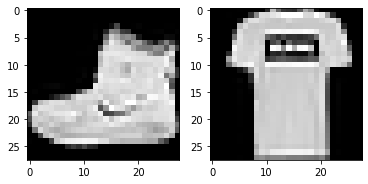

In [4]:
train_set = FashionMNIST(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
print("Number of classes is", len(train_set.classes))
plot_images(torch.stack([train_set[0][0], train_set[1][0]]))

In [5]:
dcgan_batch_size = 128
dcgan_data_loader = torch.utils.data.DataLoader(train_set, batch_size=dcgan_batch_size)
wgan_batch_size = 128
wgan_data_loader = torch.utils.data.DataLoader(train_set, batch_size=wgan_batch_size)#, shuffle=True)

# Models

In [6]:
def create_transpose_conv_block(in_channels, out_channels, kernel_size, use_batchnorm=True):
  models = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 2, 1),
            nn.ReLU()]
  if use_batchnorm:
    models.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*models)

class Generator(nn.Module):
  def __init__(self, latent_size, out_channels=1, max_channels=256, use_batchnorm=True):
    super(Generator, self).__init__()
    self.kernel_size = 4
    self.max_channels = max_channels
    self.latent_size = latent_size

    self.fc = nn.Sequential(nn.Linear(latent_size, self.kernel_size * self.kernel_size * max_channels), nn.ReLU())
    self.trans_conv1 = create_transpose_conv_block(max_channels, int(max_channels / 2), self.kernel_size)
    self.trans_conv2 = create_transpose_conv_block(int(max_channels / 2), int(max_channels / 4), self.kernel_size)
    self.out_conv = nn.Sequential(nn.ConvTranspose2d(int(max_channels / 4), out_channels, self.kernel_size, 2, 1), nn.Sigmoid())

    # todo: maybe we dont need this
    # self.initialize_variables()

  def forward(self, x):
    x = self.fc(x)
    x = x.view(-1, self.max_channels, self.kernel_size, self.kernel_size)
    x = self.trans_conv1(x)
    x = x[..., :7, :7]
    x = self.trans_conv2(x)
    x = self.out_conv(x)
    return x

  def initialize_variables(self, var=0.1):
    for param in self.parameters():
      nn.init.uniform_(param, -var, var)

  def generate_noise(self, num_of_samples, device="cpu"):
    return torch.randn((num_of_samples, self.latent_size), device=device)

  def generate_images(self, num_images=1):
    z = Variable(self.generate_noise(num_images, device=next(self.parameters()).device))
    return self.forward(z)

In [7]:
def create_conv_block(in_channels, out_channels, kernel_size, stride=2, use_batchnorm=True):
  models = [nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=2),
            nn.LeakyReLU(negative_slope=0.2)]
  if use_batchnorm:
    models.append(nn.BatchNorm2d(out_channels))
  return models

class Discriminator(nn.Module):
  def __init__(self, in_channels=1, dim=64, use_batchnorm=False, logits=True):
    super(Discriminator, self).__init__()
    self.kernel_size = 5
    # self.encoder = nn.Sequential(create_conv_block(in_channels, dim, self.kernel_size, use_batchnorm=use_batchnorm),
    #                              create_conv_block(dim, dim * 2, self.kernel_size, use_batchnorm=use_batchnorm),
    #                              create_conv_block(dim * 2, dim * 4, self.kernel_size, use_batchnorm=use_batchnorm))
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels, dim, self.kernel_size, stride=2, padding=2),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Conv2d(dim, 2 * dim, self.kernel_size, stride=2, padding=2),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Conv2d(2 * dim, 4 * dim, self.kernel_size, stride=2, padding=2),
        nn.LeakyReLU(negative_slope=0.2),
    )
    out_models = [nn.Linear(dim * 4 * 4 * 4, 1)]
    if not logits:
      out_models.append(nn.Sigmoid())
    self.fc = nn.Sequential(*out_models)

    # self.initialize_variables()

  def forward(self, x):
    x = self.encoder(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x
    
  def initialize_variables(self, var=0.1):
    for param in self.parameters():
      nn.init.uniform_(param, -var, var)

In [8]:
class DCGAN(nn.Module):
  def __init__(self, latent_size, load_models=False, models_dir=""):
    super(DCGAN, self).__init__()
    self.latent_size = latent_size
    self.models_dir = models_dir

    # definitions
    self.real_label = 1
    self.fake_label = 0
    self.critic_iters = 1  # num of critic iterations per generator interation

    self.num_steps = 0

    self.G = Generator(self.latent_size).to(device)
    self.D = Discriminator(logits=False).to(device)

    self.loss_dict = { 'G_loss' : [], 'D_loss' : [], 'GP_loss' : []}
    if load_models:
      self.G.load_state_dict(torch.load(os.path.join(models_dir, "DCGAN_generator.pt")))
      self.D.load_state_dict(torch.load(os.path.join(models_dir, "DCGAN_discriminator.pt")))
      loss_path = os.path.join(models_dir, "DCGAN_losses.json")
      with open(loss_path, 'r') as json_file:
        self.Loss_dict = json.load(json_file)
    
    self.gen_opt = optim.Adam(self.G.parameters(), lr=1e-4, betas=(0.5, 0.999))
    self.dis_opt = optim.Adam(self.D.parameters(), lr=1e-4, betas=(0.5, 0.999))

    self.g_criterion = nn.BCELoss()
    self.d_criterion = nn.BCELoss()

  def save_model(self, save_directory=None):
    if save_directory is None:
      save_directory = self.models_dir
    generator_path = os.path.join(save_directory, "DCGAN_generator.pt")
    print("Saving Generator to {}...".format(generator_path))
    torch.save(self.G.state_dict(), generator_path)

    discriminator_path = os.path.join(save_directory, "DCGAN_discriminator.pt")
    print("Saving Discriminator to {}...".format(discriminator_path))
    torch.save(self.D.state_dict(), discriminator_path)
    
    loss_path = os.path.join(save_directory, "DCGAN_losses.json")
    print("Saving Loss history to {}...".format(loss_path))
    with open(loss_path, 'w') as json_file:
      json.dump(self.loss_dict, json_file)
    
    print("Saved models and losses")

  def train_discriminator_step(self, real_images, fake_images):
    assert real_images.shape == fake_images.shape, "Real and fake images must be of same shape!"
    self.D.zero_grad()
    batch_size = real_images.shape[0]

    real_target = torch.full((batch_size, 1), self.real_label, dtype=torch.float32, device=device)
    fake_target = torch.full((batch_size, 1), self.fake_label, dtype=torch.float32, device=device)

    real_images = Variable(real_images).to(device)
    real_bce = self.d_criterion(self.D(real_images), real_target)
    # real_bce.backward()
    fake_bce = self.d_criterion(self.D(fake_images.detach()), fake_target)
    # fake_bce.backward()
    loss = (fake_bce + real_bce) / 2
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.D.parameters(), 1.)
    self.dis_opt.step()

    self.loss_dict['D_loss'].append(loss.item())

  def train_generator_step(self, generated_data):
    self.G.zero_grad()
    d_generated = self.D(generated_data)
    ones = torch.ones((generated_data.shape[0], 1), device=generated_data.device)
    loss = self.g_criterion(d_generated, ones)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.)
    self.gen_opt.step()
    self.loss_dict['G_loss'].append(loss.item())
  
  def run_training_epoch(self, dataloader, print_every=-1):
    for idx, batch in enumerate(dataloader):
      self.num_steps += 1
      data = batch[0]#.to(device)
      generated_data = self.G.generate_images(data.shape[0])

      self.train_discriminator_step(data, generated_data)
      if self.num_steps % self.critic_iters == 0:
        self.train_generator_step(generated_data)


  def train(self, data_loader, num_of_epochs, create_gif=False):
    if create_gif:
      fixed_latents = self.G.generate_noise(120).to(device)
      training_progress_images = []
    
    tic = timeit.default_timer()

    print("Start training")
    for epoch in range(num_of_epochs):
      self.run_training_epoch(data_loader)
      print("Epoch {:4d} | D: {:.3f} | G: {:.3f}".format(epoch + 1,
                                                self.loss_dict['D_loss'][-1],
                                                self.loss_dict['G_loss'][-1]))
      if create_gif:
        img_grid = make_grid(self.G(fixed_latents).cpu().data, nrow=10, normalize=True)
        img_grid = (np.transpose(img_grid.numpy(), (1, 2, 0)) * 256).astype('uint8')
        training_progress_images.append(img_grid)
      
      toc = timeit.default_timer()
      print("Epoch {} ended, training for {:d} mins".format(epoch + 1, round((toc-tic)/60)))
    
    if create_gif:
      imageio.mimsave(os.path.join(self.models_dir,
                                   'DCGAN_training_for_{}_epochs.gif'.format(num_of_epochs)),
                                   training_progress_images)
    print("Done training!")

In [9]:
def compute_gradient_penalty(discriminator, real_data, fake_data):
    assert real_data.shape == fake_data.shape, "real and fake data must be of same shape"
    batch_size = real_data.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1)
    
    alpha = alpha.expand_as(real_data).to(device)

    x_hat = real_data + alpha * (fake_data - real_data)
    x_hat = Variable(x_hat, requires_grad=True).to(device)

    disc_xhat = discriminator(x_hat)

    gradients = grad(outputs=disc_xhat, inputs=x_hat,
                    grad_outputs=torch.ones(disc_xhat.size()).to(device),
                    create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1.) ** 2).mean()
    return gradient_penalty

class WGAN(nn.Module):
  def __init__(self, latent_size, gp_lambda=10, load_models=False, models_dir=""):
    super(WGAN, self).__init__()
    self.latent_size = latent_size
    self.models_dir = models_dir
    self.gp_lambda = gp_lambda

    # definitions
    self.real_label = 1
    self.fake_label = 0
    self.critic_iters = 5  # num of critic iterations per generator interation

    self.num_steps = 0

    self.G = Generator(self.latent_size).to(device)
    self.D = Discriminator(logits=True).to(device)

    self.loss_dict = { 'G_loss' : [], 'D_loss' : [], 'GP_loss' : []}
    if load_models:
      self.G.load_state_dict(torch.load(os.path.join(models_dir, "WGAN_generator.pt")))
      self.D.load_state_dict(torch.load(os.path.join(models_dir, "WGAN_discriminator.pt")))
      loss_path = os.path.join(models_dir, "WGAN_losses.json")
      with open(loss_path, 'r') as json_file:
        self.Loss_dict = json.load(json_file)
    
    self.gen_opt = optim.Adam(self.G.parameters(), lr=1e-4, betas=(0.5, 0.9))
    self.dis_opt = optim.Adam(self.D.parameters(), lr=1e-4, betas=(0.5, 0.9))

  def save_model(self, save_directory=None):
    if save_directory is None:
      save_directory = self.models_dir
    generator_path = os.path.join(save_directory, "WGAN_generator.pt")
    print("Saving Generator to {}...".format(generator_path))
    torch.save(self.G.state_dict(), generator_path)

    discriminator_path = os.path.join(save_directory, "WGAN_discriminator.pt")
    print("Saving Discriminator to {}...".format(discriminator_path))
    torch.save(self.D.state_dict(), discriminator_path)
    
    loss_path = os.path.join(save_directory, "WGAN_losses.json")
    print("Saving Loss history to {}...".format(loss_path))
    with open(loss_path, 'w') as json_file:
      json.dump(self.loss_dict, json_file)
    
    print("Saved models and losses")

  def train_discriminator_step(self, real_images):
    self.D.zero_grad()
    batch_size = real_images.shape[0]

    fake_images = self.G.generate_images(batch_size)
    real_images = Variable(real_images).to(device)
    gradient_penalty = compute_gradient_penalty(self.D, real_images, fake_images)

    loss = self.D(fake_images).mean() - self.D(real_images).mean() + self.gp_lambda * gradient_penalty
    
    loss.backward()
    self.dis_opt.step()

    self.loss_dict['GP_loss'].append(gradient_penalty.item())
    self.loss_dict['D_loss'].append(loss.item())

  def train_generator_step(self, batch_size):
    self.G.zero_grad()
    generated_data = self.G.generate_images(batch_size)
    loss = - self.D(generated_data).mean()
    loss.backward()
    self.gen_opt.step()

    self.loss_dict['G_loss'].append(loss.item())
  
  def run_training_epoch(self, dataloader, print_every=-1):
    for idx, batch in enumerate(dataloader):
      self.num_steps += 1
      data = batch[0]#.to(device)

      self.train_discriminator_step(data)
      if self.num_steps % self.critic_iters == 0:
        self.train_generator_step(data.shape[0])


  def train(self, data_loader, num_of_epochs, create_gif=False):
    if create_gif:
      fixed_latents = self.G.generate_noise(120).to(device)
      training_progress_images = []
    
    tic = timeit.default_timer()

    print("Start training")
    for epoch in range(num_of_epochs):
      self.run_training_epoch(data_loader)
      print("Iteration {:4d} | D: {:.3f} | GP: {:.3f} | G: {:.3f}".format(
                                                epoch + 1,
                                                self.loss_dict['D_loss'][-1],
                                                self.loss_dict['GP_loss'][-1],
                                                self.loss_dict['G_loss'][-1]))
      if create_gif:
        img_grid = make_grid(self.G(fixed_latents).cpu().data, nrow=10, normalize=True)
        img_grid = (np.transpose(img_grid.numpy(), (1, 2, 0)) * 256).astype('uint8')
        training_progress_images.append(img_grid)
      
      toc = timeit.default_timer()
      print("Epoch {} ended, training for {:d} mins".format(epoch + 1, round((toc-tic)/60)))
    
    if create_gif:
      imageio.mimsave(os.path.join(self.models_dir,
                                   'WGAN_training_for_{}_epochs.gif'.format(num_of_epochs)),
                                   training_progress_images)
    print("Done training!")

# Training DCGAN

In [10]:
latent_size = 128
dcgan_num_epochs = 60
dcgan = DCGAN(latent_size, models_dir=models_dir).to(device)
dcgan.train(dcgan_data_loader, dcgan_num_epochs, create_gif=True)
dcgan.save_model(models_dir)

Start training
Epoch    1 | D: 0.630 | G: 0.779
Epoch 1 ended, training for 0 mins
Epoch    2 | D: 0.605 | G: 1.045
Epoch 2 ended, training for 1 mins
Epoch    3 | D: 0.626 | G: 0.738
Epoch 3 ended, training for 1 mins
Epoch    4 | D: 0.636 | G: 0.943
Epoch 4 ended, training for 2 mins
Epoch    5 | D: 0.627 | G: 0.672
Epoch 5 ended, training for 2 mins
Epoch    6 | D: 0.639 | G: 0.755
Epoch 6 ended, training for 3 mins
Epoch    7 | D: 0.636 | G: 0.606
Epoch 7 ended, training for 3 mins
Epoch    8 | D: 0.598 | G: 0.843
Epoch 8 ended, training for 4 mins
Epoch    9 | D: 0.584 | G: 1.348
Epoch 9 ended, training for 4 mins
Epoch   10 | D: 0.597 | G: 0.641
Epoch 10 ended, training for 4 mins
Epoch   11 | D: 0.595 | G: 0.992
Epoch 11 ended, training for 5 mins
Epoch   12 | D: 0.584 | G: 0.626
Epoch 12 ended, training for 5 mins
Epoch   13 | D: 0.592 | G: 1.026
Epoch 13 ended, training for 6 mins
Epoch   14 | D: 0.615 | G: 0.936
Epoch 14 ended, training for 6 mins
Epoch   15 | D: 0.599 | G: 1

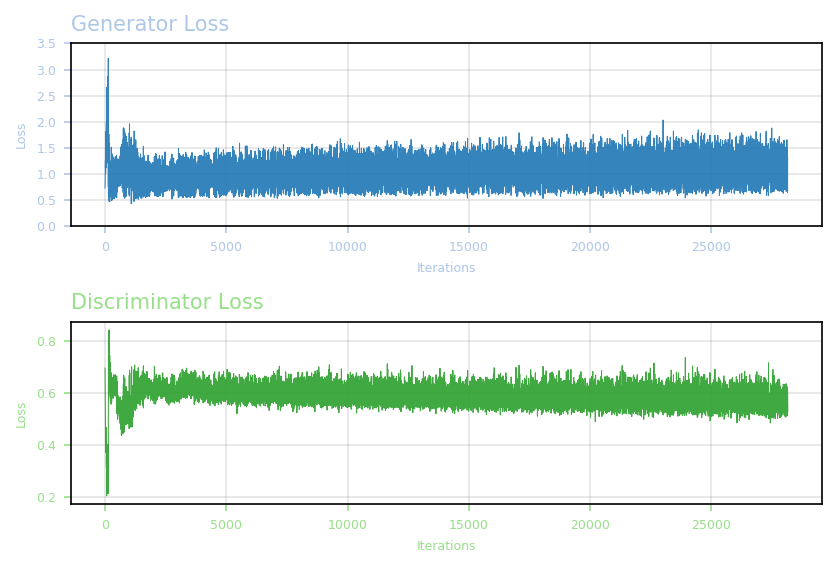

In [11]:
palette = plt.get_cmap('tab20')
base_color = 0

figure = plt.figure(1, dpi=150)
plt.rc('xtick', labelsize=6)    # fontsize of the axes labels
plt.rc('ytick', labelsize=6)    # fontsize of the axes labels
plt.rc('axes', labelsize=8)     # fontsize of the x and y labels

dcgan_data = (dcgan.loss_dict['G_loss'], dcgan.loss_dict['D_loss'])

for count, loss_list in enumerate(dcgan_data):
  axes = plt.subplot(2,1, count + 1)   # create a new subplot
  
  figure.tight_layout(pad=2.0) # add spacing between subplots
    
  plt.plot(range(1, 1 + len(loss_list)), loss_list, 
           marker='', color=palette(base_color), linewidth=0.5, alpha=0.9)
  base_color += 1
  
  # Add axes titles
  plt.ylabel("Loss", color=palette(base_color), fontsize=6)
  plt.xlabel("Iterations", color=palette(base_color), fontsize=6)

  # Add grid
  plt.tick_params('x', colors=palette(base_color), 
                  grid_color='grey', grid_alpha=0.2,
                  grid_linestyle="-")
  plt.tick_params('y', colors=palette(base_color), 
                  grid_color='grey', grid_alpha=0.2,
                  grid_linestyle="-")
  plt.grid(b=True)
  if count == 0: # Generator graph
    plt.yticks(np.arange(0, np.ceil(max(loss_list)), 0.5))

  # Add title and legend
  title = "Generator Loss" if count == 0 else "Discriminator Loss"
  plt.title(title, loc='left', fontsize=10, fontweight=0,
            color=palette(base_color))
  
  base_color += 3
plt.savefig(os.path.join(models_dir, 'DCGAN_loss_graph.jpeg'))
plt.show()

# Training WGAN

In [12]:
latent_size = 128
wgan_num_epochs = 80
wgan = WGAN(latent_size, models_dir=models_dir).to(device)
wgan.train(wgan_data_loader, wgan_num_epochs, create_gif=True)
wgan.save_model(models_dir)

Start training
Iteration    1 | D: -678.818 | GP: 48.309 | G: 994.491
Epoch 1 ended, training for 1 mins
Iteration    2 | D: -530.133 | GP: 48.747 | G: -36.355
Epoch 2 ended, training for 1 mins
Iteration    3 | D: -563.106 | GP: 49.847 | G: -502.184
Epoch 3 ended, training for 2 mins
Iteration    4 | D: -478.976 | GP: 44.233 | G: -849.248
Epoch 4 ended, training for 2 mins
Iteration    5 | D: -417.727 | GP: 33.837 | G: -1306.791
Epoch 5 ended, training for 3 mins
Iteration    6 | D: -429.407 | GP: 36.684 | G: -1151.826
Epoch 6 ended, training for 4 mins
Iteration    7 | D: -419.388 | GP: 36.496 | G: -1812.637
Epoch 7 ended, training for 4 mins
Iteration    8 | D: -421.506 | GP: 35.547 | G: -1802.166
Epoch 8 ended, training for 5 mins
Iteration    9 | D: -408.627 | GP: 36.788 | G: -1645.297
Epoch 9 ended, training for 5 mins
Iteration   10 | D: -424.027 | GP: 36.375 | G: -1798.881
Epoch 10 ended, training for 6 mins
Iteration   11 | D: -426.532 | GP: 35.802 | G: -1655.775
Epoch 11 ende

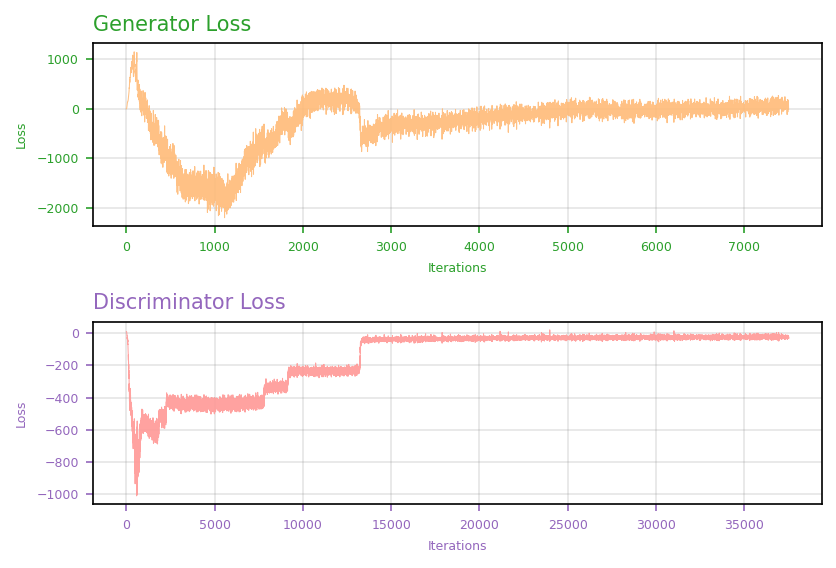

In [13]:
palette = plt.get_cmap('tab20')
base_color = 3
figure = plt.figure(1, dpi=150)
plt.rc('xtick', labelsize=6)    # fontsize of the axes labels
plt.rc('ytick', labelsize=6)    # fontsize of the axes labels
plt.rc('axes', labelsize=8)     # fontsize of the x and y labels

wgan_data = (wgan.loss_dict['G_loss'], wgan.loss_dict['D_loss'])

for count, loss_list in enumerate(wgan_data):
  axes = plt.subplot(2,1, count + 1)   # create a new subplot

  figure.tight_layout(pad=2.0) # add spacing between subplots
  
  plt.plot(range(1, 1 + len(loss_list)), loss_list, 
           marker='', color=palette(base_color), linewidth=0.5, alpha=0.9)
  base_color += 1
  
  # Add axes titles
  plt.ylabel("Loss", color=palette(base_color), fontsize=6)
  plt.xlabel("Iterations", color=palette(base_color), fontsize=6)

  # Add grid
  plt.tick_params('x', colors=palette(base_color), 
                  grid_color='grey', grid_alpha=0.2,
                  grid_linestyle="-")
  plt.tick_params('y', colors=palette(base_color), 
                  grid_color='grey', grid_alpha=0.2,
                  grid_linestyle="-")
  plt.grid(b=True)

  # Add title and legend
  title = "Generator Loss" if count == 0 else "Discriminator Loss"
  plt.title(title, loc='left', fontsize=10, fontweight=0,
            color=palette(base_color))
  
  base_color += 3
plt.savefig(os.path.join(models_dir, 'WGAN_loss_graph.jpeg'))
plt.show()

# Load PreTrained Models and Evaluate

In [14]:
latent_size = 128
dcgan = DCGAN(latent_size, load_models=True, models_dir=models_dir).to(device)
wgan = WGAN(latent_size, load_models=True, models_dir=models_dir).to(device)

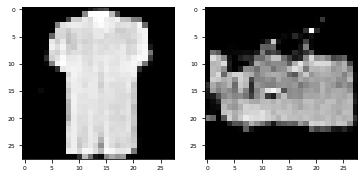

In [15]:
plot_images(dcgan.G.generate_images(2))

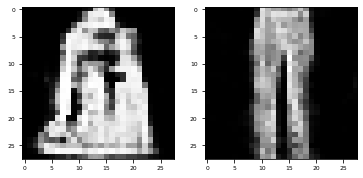

In [16]:
plot_images(wgan.G.generate_images(2))